# 2D DPP conforming Galerkin FEM

In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd

import logging

from perphil.forms.spaces import create_function_spaces
from perphil.forms.dpp import dpp_form
from perphil.mesh.builtin import create_mesh
from perphil.models.dpp.parameters import DPPParameters
from perphil.solvers.conditioning import (
    get_matrix_data_from_form,
    calculate_condition_number,
)
from perphil.solvers.solver import (
    solve_dpp,
    solve_dpp_nonlinear,
    logger,
)
from perphil.solvers.parameters import (
    LINEAR_SOLVER_PARAMS,
    GMRES_PARAMS,
    FIELDSPLIT_LU_PARAMS,
    GMRES_JACOBI_PARAMS,
    RICHARDSON_SOLVER_PARAMS,
)
from perphil.utils.plotting import plot_2d_mesh, plot_scalar_field, plot_vector_field
from perphil.utils.manufactured_solutions import interpolate_exact
from perphil.utils.postprocessing import (
    split_dpp_solution,
    calculate_darcy_velocity_from_pressure,
    slice_along_x,
)

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

## Case 1

### Mesh

In [3]:
mesh = create_mesh(10, 10, quadrilateral=True)

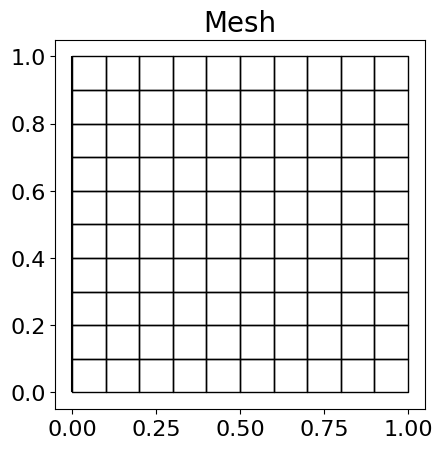

In [4]:
plot_2d_mesh(mesh)

### Exact solutions

In [5]:
U, V = create_function_spaces(
    mesh,
    velocity_deg=1,
    pressure_deg=1,
    velocity_family="CG",
    pressure_family="CG",
)

dpp_params = DPPParameters(k1=1.0, k2=1 / 1e2, beta=1.0, mu=1)
u1_exact, p1_exact, u2_exact, p2_exact = interpolate_exact(mesh, U, V, dpp_params)

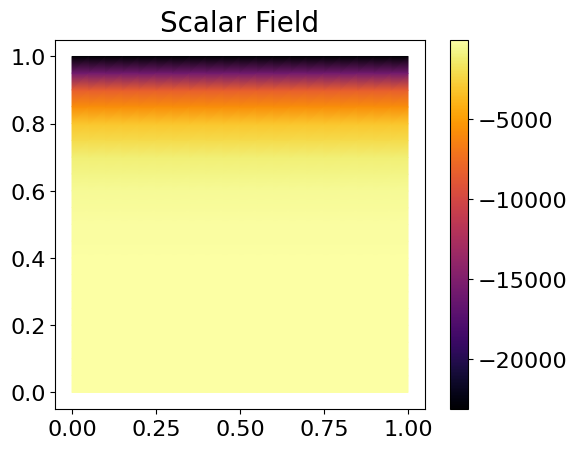

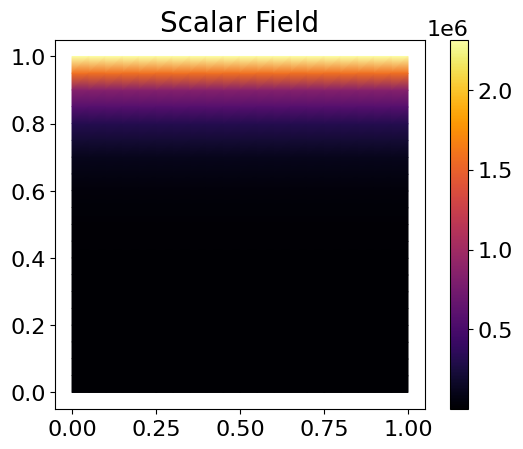

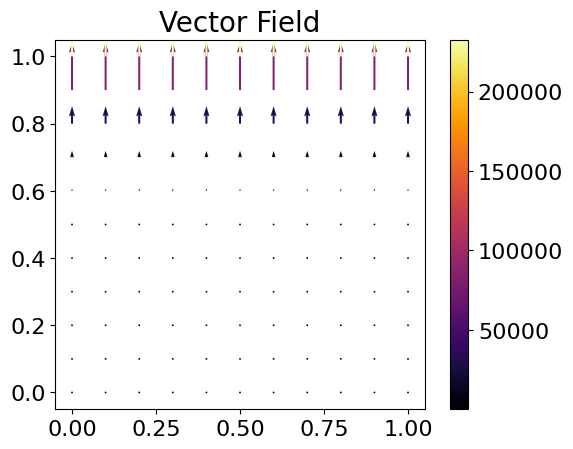

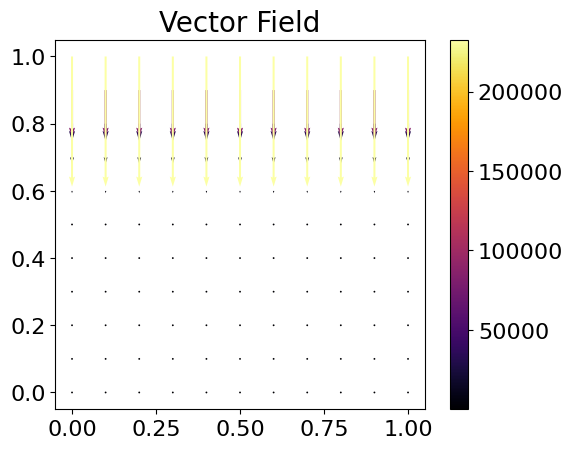

In [6]:
plot_scalar_field(p1_exact)
plot_scalar_field(p2_exact)
plot_vector_field(u1_exact)
plot_vector_field(u2_exact)

### Conforming Galerkin FEM approximations

#### Monolithic (fully coupled) approximation

In [7]:
W = V * V  # Mixed function space with both scales

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

solver_parameters = LINEAR_SOLVER_PARAMS
solution_data_monolithic = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_monolithic = solution_data_monolithic.solution
p1_monolithic, p2_monolithic = split_dpp_solution(solution_monolithic)

u1_monolithic = calculate_darcy_velocity_from_pressure(p1_monolithic, dpp_params.k1)

u2_monolithic = calculate_darcy_velocity_from_pressure(p2_monolithic, dpp_params.k2)

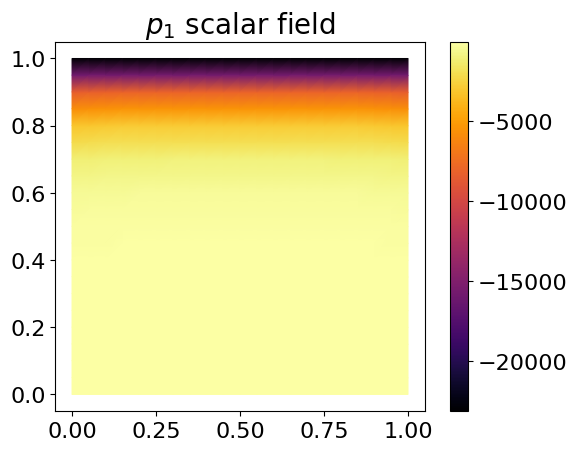

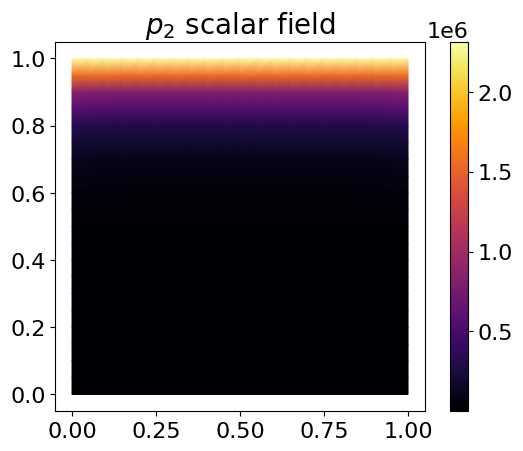

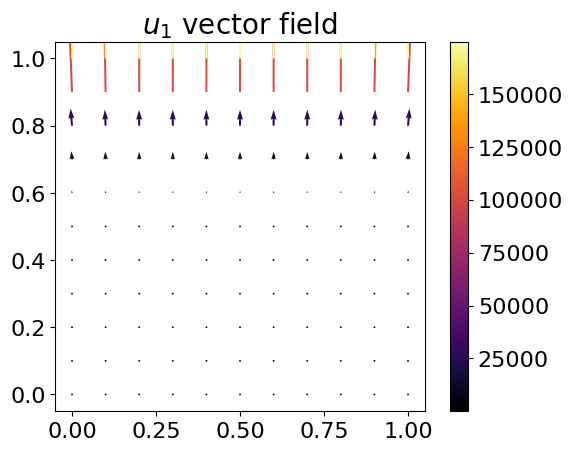

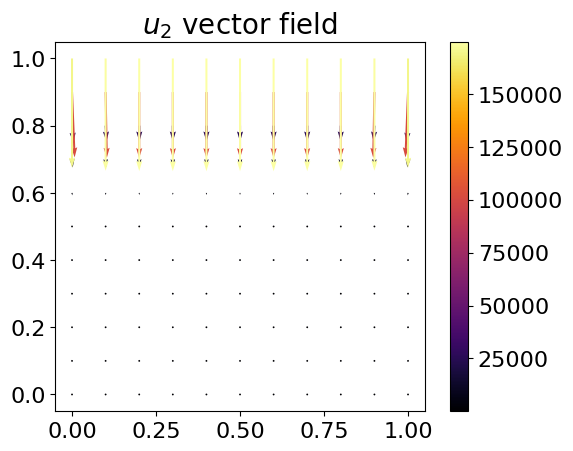

In [8]:
plot_scalar_field(p1_monolithic, title=r"$p_1$ scalar field")
plot_scalar_field(p2_monolithic, title=r"$p_2$ scalar field")
plot_vector_field(u1_monolithic, title=r"$u_1$ vector field")
plot_vector_field(u2_monolithic, title=r"$u_2$ vector field")

In [9]:
x_mid_point = 0.5
y_points, p1_mono_at_x_mid_point = slice_along_x(p1_monolithic, x_value=x_mid_point)
_, p1_exact_at_x_mid_point = slice_along_x(p1_exact, x_value=x_mid_point)
_, p2_mono_at_x_mid_point = slice_along_x(p2_monolithic, x_value=x_mid_point)
_, p2_exact_at_x_mid_point = slice_along_x(p2_exact, x_value=x_mid_point)

y_points, p1_mono_at_x_mid_point, p2_mono_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.49946480e+00, -4.38933558e+00, -1.36593392e+01,
        -4.08656173e+01, -1.19075697e+02, -3.42986552e+02, -9.83987764e+02,
        -2.81995567e+03, -8.08018988e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.97166457e+02, 5.28751291e+02, 1.48955743e+03,
        4.23188988e+03, 1.20603767e+04, 3.44439833e+04, 9.85224000e+04,
        2.82085384e+05, 8.08066208e+05, 2.31529069e+06]))

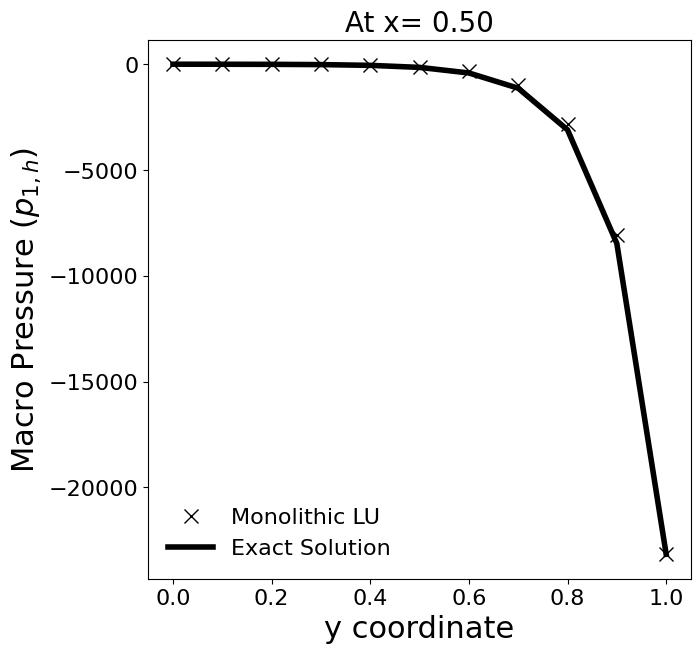

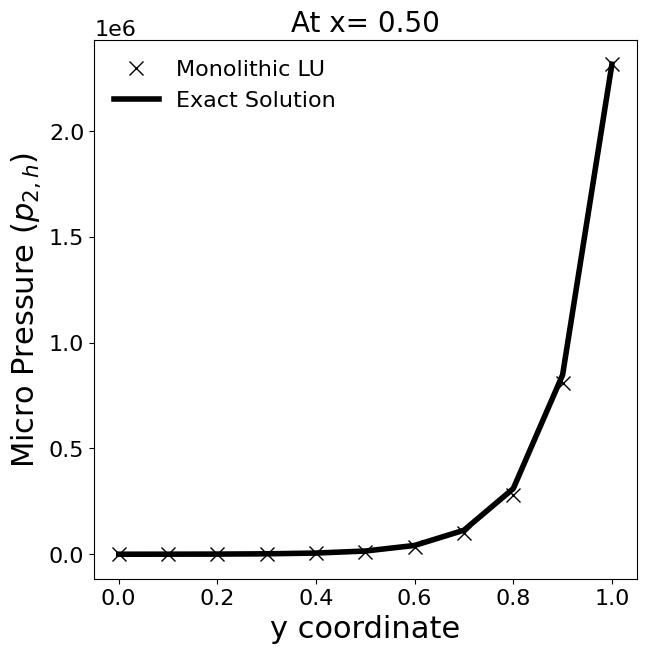

In [10]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points, p1_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Scale-splitting

Pre-conditioner by scale:

In [35]:
solver_monitoring_param = {
    "ksp_monitor": None,
    "snes_rtol": 0,
    "snes_atol": 0,
    "snes_stol": 1e-8,
}
solver_parameters = {**GMRES_PARAMS, **FIELDSPLIT_LU_PARAMS, **solver_monitoring_param}
solution_data_preconditioned = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_preconditioned = solution_data_preconditioned.solution
p1_preconditioned, p2_preconditioned = split_dpp_solution(solution_preconditioned)

u1_preconditioned = calculate_darcy_velocity_from_pressure(
    p1_preconditioned, dpp_params.k1
)

u2_preconditioned = calculate_darcy_velocity_from_pressure(
    p2_preconditioned, dpp_params.k2
)

    Residual norms for dpp_ solve.
    0 KSP Residual norm 2.579294048667e+06
    1 KSP Residual norm 4.826558204558e+04
    2 KSP Residual norm 7.122478054650e+02
    3 KSP Residual norm 4.055258380528e+00
    4 KSP Residual norm 8.155414748172e-03
    5 KSP Residual norm 7.145565823259e-06
    6 KSP Residual norm 5.245017940560e-09


In [12]:
solver_monitoring_param = {
    "ksp_monitor": None,
}
solver_parameters = {**GMRES_JACOBI_PARAMS, **solver_monitoring_param}
solution_data_gmres_jacobi = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_gmres_jacobi = solution_data_gmres_jacobi.solution
p1_gmres_jacobi, p2_gmres_jacobi = split_dpp_solution(solution_gmres_jacobi)

u1_gmres_jacobi = calculate_darcy_velocity_from_pressure(p1_gmres_jacobi, dpp_params.k1)

u2_gmres_jacobi = calculate_darcy_velocity_from_pressure(p2_gmres_jacobi, dpp_params.k2)

    Residual norms for dpp_ solve.
    0 KSP Residual norm 1.928816876943e+06
    1 KSP Residual norm 5.338040265445e+05
    2 KSP Residual norm 1.720021586590e+05
    3 KSP Residual norm 5.679123808532e+04
    4 KSP Residual norm 1.877121187171e+04
    5 KSP Residual norm 6.100994208874e+03
    6 KSP Residual norm 2.014884089703e+03
    7 KSP Residual norm 6.624058878822e+02
    8 KSP Residual norm 2.238209610088e+02
    9 KSP Residual norm 6.461370402885e+01
   10 KSP Residual norm 4.890017856838e+01
   11 KSP Residual norm 3.293092016419e+01
   12 KSP Residual norm 1.932543678678e+01
   13 KSP Residual norm 1.552282667896e+01
   14 KSP Residual norm 9.604268477585e+00
   15 KSP Residual norm 2.781934118569e+00
   16 KSP Residual norm 7.852621188043e-01
   17 KSP Residual norm 3.696598362630e-01
   18 KSP Residual norm 1.641574167698e-01
   19 KSP Residual norm 2.797739250967e-02
   20 KSP Residual norm 4.905458961745e-03
   21 KSP Residual norm 1.114570830208e-03
   22 KSP Residual 

In [13]:
y_points, p1_pc_at_x_mid_point = slice_along_x(p1_preconditioned, x_value=x_mid_point)
_, p2_pc_at_x_mid_point = slice_along_x(p2_preconditioned, x_value=x_mid_point)

y_points, p1_pc_at_x_mid_point, p2_pc_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.49946480e+00, -4.38933557e+00, -1.36593392e+01,
        -4.08656173e+01, -1.19075697e+02, -3.42986552e+02, -9.83987764e+02,
        -2.81995567e+03, -8.08018988e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.97166457e+02, 5.28751291e+02, 1.48955743e+03,
        4.23188988e+03, 1.20603767e+04, 3.44439833e+04, 9.85224000e+04,
        2.82085384e+05, 8.08066208e+05, 2.31529069e+06]))

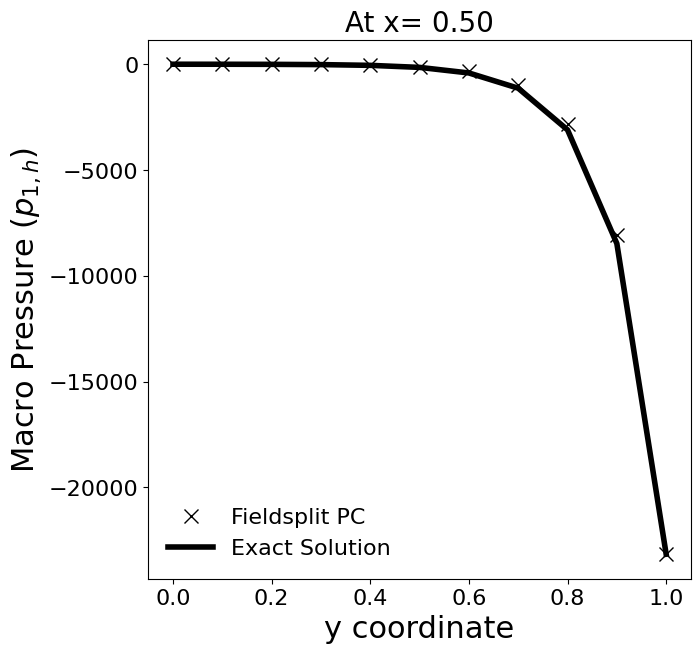

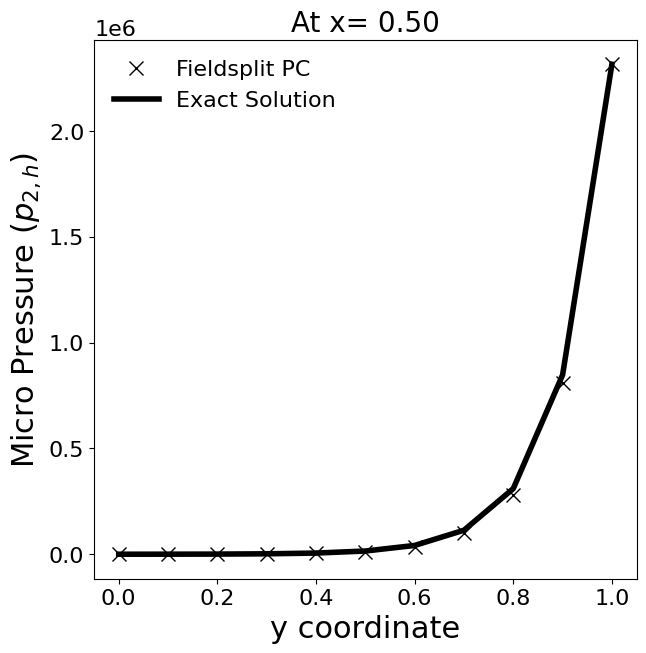

In [14]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

PETSc's Richardson iterations:

In [34]:
solver_monitoring_param = {
    "snes_monitor": None,
    "snes_rtol": 0,
    "snes_atol": 0,
    "snes_stol": 1e-8,
}
solver_parameters = {**RICHARDSON_SOLVER_PARAMS, **solver_monitoring_param}
solution_data_richardson = solve_dpp_nonlinear(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_richardson = solution_data_richardson.solution
p1_richardson, p2_richardson = split_dpp_solution(solution_richardson)

u1_richardson = calculate_darcy_velocity_from_pressure(p1_richardson, dpp_params.k1)

u2_richardson = calculate_darcy_velocity_from_pressure(p2_richardson, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
  1 SNES Function norm 6.540707786995e+04
  2 SNES Function norm 6.117725608385e+04
  3 SNES Function norm 5.912769612821e+04
  4 SNES Function norm 5.774442669844e+04
  5 SNES Function norm 5.664110395132e+04
  6 SNES Function norm 5.568082822456e+04
  7 SNES Function norm 5.480456503096e+04
  8 SNES Function norm 5.398317143008e+04
  9 SNES Function norm 5.320069863893e+04
 10 SNES Function norm 5.244771842018e+04
 11 SNES Function norm 5.171833167007e+04
 12 SNES Function norm 5.100868266234e+04
 13 SNES Function norm 5.031615635965e+04
 14 SNES Function norm 4.963891707693e+04
 15 SNES Function norm 4.897563178566e+04
 16 SNES Function norm 4.832529921308e+04
 17 SNES Function norm 4.768714197302e+04
 18 SNES Function norm 4.706053724758e+04
 19 SNES Function norm 4.644497148954e+04
 20 SNES Function norm 4.584001031318e+04
 21 SNES Function norm 4.524527811621e+04
 22 SNES Function norm 4.466044401842e+04
 23 SNES Function norm 4.408521195

In [16]:
y_points, p1_richardson_at_x_mid_point = slice_along_x(
    p1_richardson, x_value=x_mid_point
)
_, p2_richardson_at_x_mid_point = slice_along_x(p2_richardson, x_value=x_mid_point)

y_points, p1_richardson_at_x_mid_point, p2_richardson_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.70091088e+00, -4.78082705e+00, -1.42163498e+01,
        -4.15480328e+01, -1.19826385e+02, -3.43733025e+02, -9.84648455e+02,
        -2.82045088e+03, -8.08045544e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.94076775e+02, 5.22498054e+02, 1.48011043e+03,
        4.21946962e+03, 1.20456855e+04, 3.44283557e+04, 9.85077576e+04,
        2.82073929e+05, 8.08059899e+05, 2.31529069e+06]))

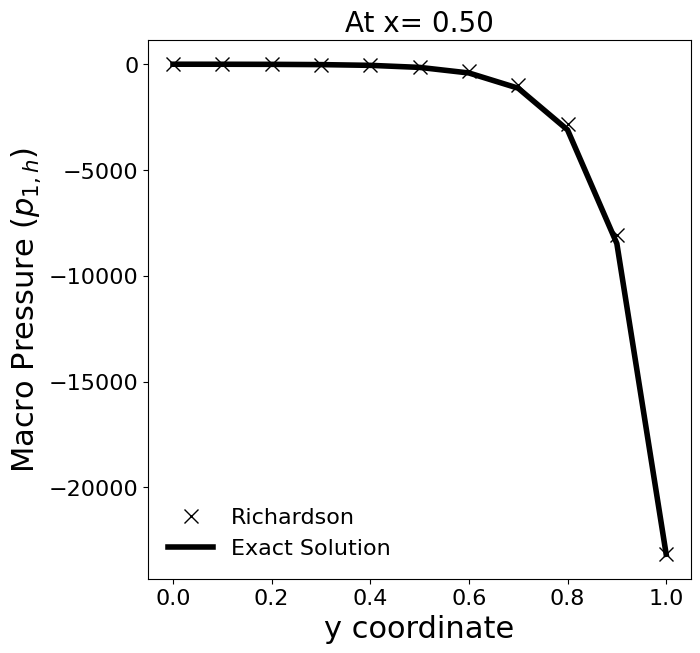

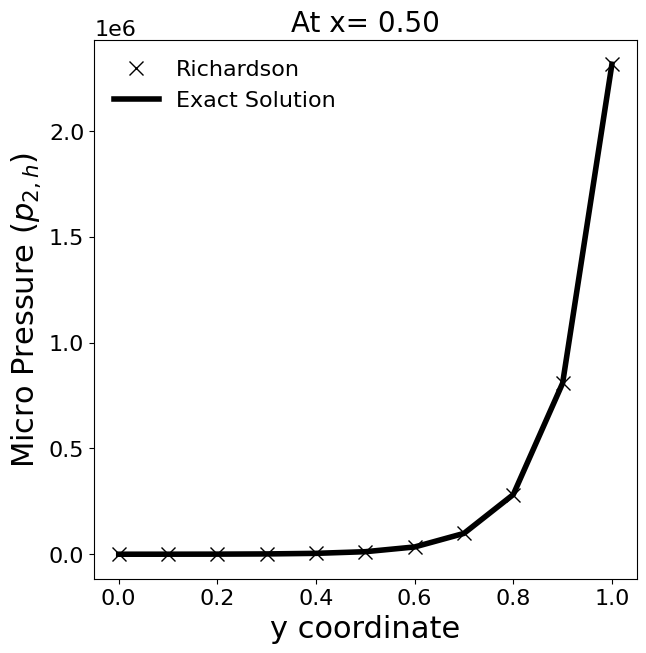

In [17]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points, p1_richardson_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Richardson"
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Richardson")
plt.plot(y_points, p2_richardson_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Loop-based Picard fixed-point iterations:

In [18]:
# Set the logger in Picard loop-based to INFO level.
# This way, iterations are displayed in cell outputs.
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("%(levelname)s %(name)s: %(message)s"))
logger.addHandler(handler)

In [31]:
solver_monitoring_param = {
    "snes_monitor": None,
}
NGS_SOLVER_PARAMS = {
    "snes_type": "ngs",
    "snes_max_it": 10000,
    "snes_stol": 1e-8,
    **FIELDSPLIT_LU_PARAMS,
}
solver_parameters = {**NGS_SOLVER_PARAMS, **solver_monitoring_param}
solution_data_ngs = solve_dpp_nonlinear(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_ngs = solution_data_ngs.solution
p1_picard, p2_picard = split_dpp_solution(solution_ngs)

u1_picard = calculate_darcy_velocity_from_pressure(p1_picard, dpp_params.k1)

u2_picard = calculate_darcy_velocity_from_pressure(p2_picard, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
  1 SNES Function norm 2.046460224212e+04
  2 SNES Function norm 5.584382518230e+03
  3 SNES Function norm 1.846502296848e+03
  4 SNES Function norm 9.030727386571e+02
  5 SNES Function norm 5.982207459510e+02
  6 SNES Function norm 4.431849090876e+02
  7 SNES Function norm 3.389976613228e+02
  8 SNES Function norm 2.641975248049e+02
  9 SNES Function norm 2.097903406659e+02
 10 SNES Function norm 1.697462854385e+02
 11 SNES Function norm 1.396902943076e+02
 12 SNES Function norm 1.165538955869e+02
 13 SNES Function norm 9.826845739003e+01
 14 SNES Function norm 8.347082901642e+01
 15 SNES Function norm 7.126507511866e+01
 16 SNES Function norm 6.105279017784e+01
 17 SNES Function norm 5.242184881255e+01
 18 SNES Function norm 4.507705653323e+01
 19 SNES Function norm 3.879807152534e+01
 20 SNES Function norm 3.341409521232e+01
 21 SNES Function norm 2.878854549146e+01
 22 SNES Function norm 2.480958069687e+01
 23 SNES Function norm 2.138404343

In [ ]:
# solver_parameters = {
#     **LINEAR_SOLVER_PARAMS,
# }
# bc_macro = fd.DirichletBC(V, p1_exact, "on_boundary")
# bc_micro = fd.DirichletBC(V, p2_exact, "on_boundary")
# solution_data_picard = solve_dpp_picard(
#     V,
#     V,
#     dpp_params,
#     bcs_macro=[bc_macro],
#     bcs_micro=[bc_micro],
#     macro_solver_parameters=solver_parameters,
#     micro_solver_parameters=solver_parameters,
# )
# p1_picard, p2_picard = solution_data_picard.solution

# u1_picard = calculate_darcy_velocity_from_pressure(p1_picard, dpp_params.k1)

# u2_picard = calculate_darcy_velocity_from_pressure(p2_picard, dpp_params.k2)

/home/diego/perphil/.venv/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/home/diego/perphil/.venv/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` 

AttributeError: 'CoordinatelessFunction' object has no attribute 'set'

In [22]:
y_points, p1_picard_at_x_mid_point = slice_along_x(p1_picard, x_value=x_mid_point)
_, p2_picard_at_x_mid_point = slice_along_x(p2_picard, x_value=x_mid_point)

y_points, p1_picard_at_x_mid_point, p2_picard_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-9.99999344e-01, -1.73016773e+00, -4.79028529e+00, -1.42005675e+01,
        -4.15013032e+01, -1.19821010e+02, -3.43672064e+02, -9.84513835e+02,
        -2.82034831e+03, -8.08042205e+03, -2.31529069e+04]),
 array([1.00000001e+02, 1.96953514e+02, 5.28314207e+02, 1.48897426e+03,
        4.23119295e+03, 1.20596943e+04, 3.44432960e+04, 9.85218572e+04,
        2.82084969e+05, 8.08065996e+05, 2.31529069e+06]))

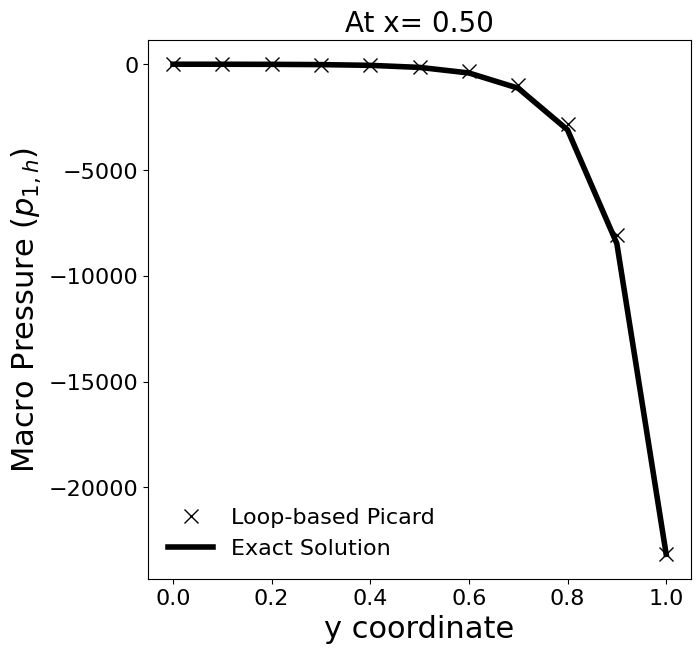

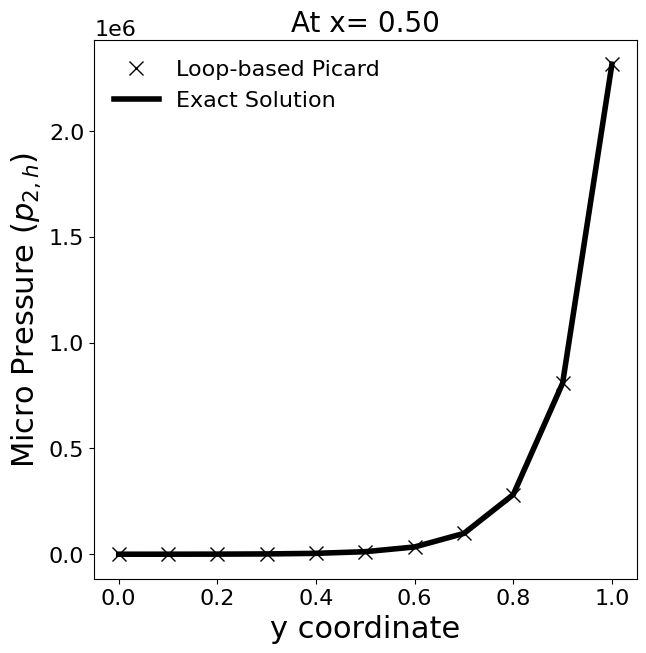

In [23]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points,
    p1_picard_at_x_mid_point,
    "x",
    ms=10,
    lw=4,
    c="k",
    label="Loop-based Picard",
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Loop-based Picard"
)
plt.plot(y_points, p2_picard_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Conditioning Analysis

##### Monolithic system

Get the variational form:

In [22]:
monolithic_lhs_form, _ = dpp_form(W=W, model_params=dpp_params)
matrix_data = get_matrix_data_from_form(monolithic_lhs_form, boundary_conditions=bcs)
monolithic_system_condition_number = calculate_condition_number(
    matrix_data.sparse_csr_data,
    num_of_factors=matrix_data.number_of_dofs - 1,
)
print(f"Monolithic system Condition Number: {monolithic_system_condition_number}")

Monolithic system Condition Number: 8722.993706018511


In [ ]:
# # Approximation degree
# degree = 1

# # Function space declaration
# pressure_family = "CG"
# velocity_family = "CG"
# U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
# V = fd.FunctionSpace(mesh, pressure_family, degree)
# W = V * V

# # Trial and test functions
# dpp_fields = fd.Function(W)
# p1, p2 = fd.TrialFunctions(W)
# q1, q2 = fd.TestFunctions(W)

# # Forcing function
# f = fd.Constant(0.0)

# # Dirichlet BCs
# bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
# bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
# bcs = [bc_macro, bc_micro]

# # Variational form
# ## Mass transfer term
# xi = -beta / mu * (p1 - p2)

# ## Macro terms
# a = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi * q1 * dx
# L = f * q1 * dx

# ## Micro terms
# a += (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi * q2 * dx
# L += f * q2 * dx

# # Isolate LHS
# F = a - L
# a_form = fd.lhs(F)

Assemble and get the associated matrix:

In [ ]:
# A = fd.assemble(a_form, bcs=bcs, mat_type="aij")
# petsc_mat = A.M.handle
# is_symmetric = petsc_mat.isSymmetric(tol=1e-8)
# size = petsc_mat.getSize()
# Mnp = csr_matrix(petsc_mat.getValuesCSR()[::-1], shape=size)

Get DoF number and clean matrix:

In [ ]:
# Mnp.eliminate_zeros()
# nnz = Mnp.nnz
# number_of_dofs = W.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom: {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

Convenient function to calculate spectral Condition Number using `scipy`:

In [ ]:
# def calculate_condition_number(
#     A: petsc4py.PETSc.Mat,
#     num_of_factors: int,
#     use_sparse: bool = False,
#     zero_tol: float = 1e-5,
# ) -> float | np.float64:
#     size = A.getSize()
#     Mnp = csr_matrix(A.getValuesCSR()[::-1], shape=size)
#     Mnp.eliminate_zeros()

#     if use_sparse:
#         singular_values = svds(
#             A=Mnp,
#             k=num_of_factors,
#             which="LM",
#             maxiter=5000,
#             return_singular_vectors=False,
#             solver="lobpcg",
#         )
#     else:
#         M = Mnp.toarray()
#         singular_values = svd(M, compute_uv=False, check_finite=False)

#     singular_values = singular_values[singular_values > zero_tol]

#     condition_number = singular_values.max() / singular_values.min()

#     return condition_number

Condition Number for the monolithic (all scales) matrix system:

In [ ]:
# monolithic_system_condition_number = calculate_condition_number(
#     A=petsc_mat, num_of_factors=num_of_factors
# )

# print(f"Monolithic system Condition Number: {monolithic_system_condition_number}")

##### Scale-splitting

In [ ]:
# # Approximation degree
# degree = 1

# # Function space declaration
# pressure_family = "CG"
# velocity_family = "CG"
# U = fd.VectorFunctionSpace(mesh, velocity_family, degree)
# V = fd.FunctionSpace(mesh, pressure_family, degree)

# # Trial and test functions
# p1 = fd.TrialFunction(V)
# p2 = fd.TrialFunction(V)
# q1 = fd.TestFunction(V)
# q2 = fd.TestFunction(V)

# # Forcing function
# f = fd.Constant(0.0)

# # Dirichlet BCs
# bc_macro = fd.DirichletBC(V, p1_exact, "on_boundary")
# bc_micro = fd.DirichletBC(V, p2_exact, "on_boundary")

# # Staggered pressures
# p1_old = fd.interpolate(fd.Constant(0), V)
# p2_old = fd.interpolate(fd.Constant(0), V)

# # Variational form
# ## Mass transfer term
# xi_macro = -beta / mu * (p1 - p2_old)
# xi_micro = -beta / mu * (p1_old - p2)

# ## Macro terms
# a_1 = (k1 / mu) * inner(grad(p1), grad(q1)) * dx - xi_macro * q1 * dx
# L_1 = f * q1 * dx
# F_macro = a_1 - L_1
# a_macro = fd.lhs(F_macro)
# L_macro = fd.rhs(F_macro)

# ## Micro terms
# a_2 = (k2 / mu) * inner(grad(p2), grad(q2)) * dx + xi_micro * q2 * dx
# L_2 = f * q2 * dx
# F_micro = a_2 - L_2
# a_micro = fd.lhs(F_micro)
# L_micro = fd.rhs(F_micro)

In [ ]:
# # Macro
# A_macro = fd.assemble(a_macro, bcs=bc_macro, mat_type="aij")
# petsc_mat_macro = A_macro.M.handle
# is_symmetric_macro = petsc_mat_macro.isSymmetric(tol=1e-8)
# size_macro = petsc_mat_macro.getSize()
# Mnp_macro = csr_matrix(petsc_mat_macro.getValuesCSR()[::-1], shape=size_macro)

# # Micro
# A_micro = fd.assemble(a_micro, bcs=bc_micro, mat_type="aij")
# petsc_mat_micro = A_micro.M.handle
# is_symmetric_micro = petsc_mat_micro.isSymmetric(tol=1e-8)
# size_micro = petsc_mat_micro.getSize()
# Mnp_micro = csr_matrix(petsc_mat_micro.getValuesCSR()[::-1], shape=size_micro)

In [ ]:
# Mnp_macro.eliminate_zeros()
# nnz = Mnp_macro.nnz
# number_of_dofs = V.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom (Macro): {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

In [ ]:
# Mnp_micro.eliminate_zeros()
# nnz = Mnp_micro.nnz
# number_of_dofs = V.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom (Micro): {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

In [ ]:
# macro_system_condition_number = calculate_condition_number(
#     A=petsc_mat_macro, num_of_factors=num_of_factors
# )
# micro_system_condition_number = calculate_condition_number(
#     A=petsc_mat_micro, num_of_factors=num_of_factors
# )

# print(f"Macro system Condition Number: {macro_system_condition_number}")
# print(f"Micro system Condition Number: {micro_system_condition_number}")